In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import os
import random
import pickle
import cv2 
# from sklearn.decomposition import PCA
# from libs import vgg16 # Download here! https://github.com/pkmital/CADL/tree/master/session-4/libs
# from libs import gif

labels = '/home/roland/celebrity_dataset/list_attr_celeba.txt'
PATH_IMAGES = '/home/roland/celebrity_dataset/img_align_celeba/'

IMAGE_WIDTH = 178
IMAGE_HEIGHT = 218
COLOR_CHANNEL_COUNT = 3
txt = open(labels).readlines()
n_els = int(txt[0].strip())
labels = txt[1].strip().split()
n_labels = len(labels)
attributes = np.zeros((n_els, n_labels), dtype=bool)
filenames = []
for i, txt_i in enumerate(txt[2:]):
    attributes[i] = (np.array(txt_i.strip().split()[1:]).astype(int) > 0)
    filenames.append(txt_i.strip().split()[0])
#pd.read_csv(labels, sep=' ')

In [2]:
print(labels)
# MALE = 20
# ATTRACTIVENESS = 2
ATTRACTIVE_IDX = 2

    
for i in range(100):
    image = plt.imread("/home/roland/celebrity_dataset/img_align_celeba/"+filenames[i])
    #plt.imshow(image)
    #plt.show()
    if attributes[i][ATTRACTIVE_IDX]:
        print("beauty!")
    else:
        print('ugly!')
print(attributes[:10])
print(filenames[:10])


['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
beauty!
ugly!
ugly!
beauty!
beauty!
beauty!
beauty!
ugly!
beauty!
beauty!
beauty!
beauty!
ugly!
ugly!
ugly!
ugly!
ugly!
ugly!
beauty!
ugly!
ugly!
ugly!
beauty!
beauty!
ugly!
beauty!
beauty!
beauty!
beauty!
ugly!
ugly!
ugly!
beauty!
beauty!
beauty!
ugly!
ugly!
beauty!
beauty!
beauty!
beauty!
beauty!
beauty!
ugly!
beauty!
beauty!
ugly!
ugly!
ugly!
beauty!
ugly!
ugly!
ugly!
beauty!
ugly!
beauty!
beauty!
beauty!
ugl

(218, 178, 3)
beauty!
(218, 178, 3)
beauty!
(218, 178, 3)
ugly!
(218, 178, 3)
ugly!
(218, 178, 3)
beauty!
(218, 178, 3)
ugly!
(218, 178, 3)
beauty!
(218, 178, 3)
ugly!
(218, 178, 3)
beauty!
(218, 178, 3)
ugly!


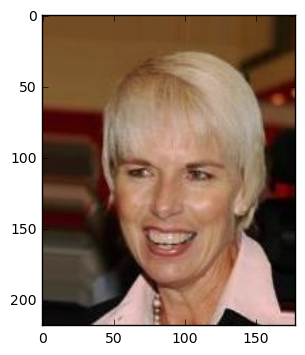

In [14]:

def get_random_image_and_is_pretty(filenames,attributes):
    index_image = random.randint(0,len(filenames)-1)
    name_picture = filenames[index_image]
    path_file = os.path.join(PATH_IMAGES,name_picture)
    image = plt.imread(path_file)
    return image,attributes[index_image][ATTRACTIVE_IDX]



def resize_image(image,width,height):
    """Resizes image"""
    return cv2.resize(image,(width,height))



def resize_image_by_cropping(image,width,height):
    """Resizes image by cropping the relevant part out of the image"""
    original_height = len(image)
    original_width = len(image[0])
    start_h = (original_height - height)//2
    start_w = (original_width - width)//2
    return image[start_h:start_h+height,start_w:start_w+width]


class ImageLoader:
    def get_random_images_from_set(self,count,names_images,attributes):
        Xs = []
        Ys = []
        for _ in range(count):           
            index = random.randint(0,len(names_images)-1)
            name_orig = os.path.join(self.path,names_images[index])
            loaded_image = plt.imread(name_orig)
            resized_image = resize_image_by_cropping(loaded_image,IMAGE_WIDTH,IMAGE_HEIGHT)
            Xs.append( resized_image)
            Ys.append( attributes[index][ATTRACTIVE_IDX])
        return np.array(Xs),np.array(Ys)
    
    def get_train_images(self,count):
        return self.get_random_images_from_set(count,self.trainimage_names,self.trainattributes)
    
    def get_test_images(self,count):
        return self.get_random_images_from_set(count,self.testimage_names,self.testattributes)
    
    def __init__(self,path,image_names,attributes,trainsplit_ratio=0.8):
        assert trainsplit_ratio > 0.0
        assert trainsplit_ratio < 1.0
        self.path = path
        self.trainimage_names = image_names[:int(trainsplit_ratio*len(image_names))]
        self.testimage_names = image_names[int(trainsplit_ratio*len(image_names)):]
        self.trainattributes = attributes[:int(trainsplit_ratio*len(image_names))]
        self.testattributes = attributes[:int(trainsplit_ratio*len(image_names))]

        
dataloader = ImageLoader(PATH_IMAGES,filenames,attributes)
images,ispretty = dataloader.get_train_images(10)

for i in range(len(images)):
    image,is_pretty = images[i],ispretty[i]
    print(image.shape)
    plt.imshow(image)
    #plt.show()
    if is_pretty:
        print("beauty!")
    else:
        print('ugly!')

        
# for _ in range(10):
#     image,is_pretty = get_random_image_and_is_pretty(filenames,attributes)
#     plt.imshow(image)
#     plt.show()
#     if is_pretty:
#         print("beauty!")
#     else:
#         print('ugly!')

In [4]:

def conv_layer(input_image,ksize,in_channels,out_channels,stride,scope_name,activation_function=tf.nn.relu,batch_normalise=True):
    with tf.variable_scope(scope_name):
        filter = tf.Variable(tf.random_normal([ksize,ksize,in_channels,out_channels],stddev=0.05))
        output = tf.nn.conv2d(input_image,filter, strides=[1, stride, stride, 1], padding='SAME')
        
        if batch_normalise:
            batch_mean2, batch_var2 = tf.nn.moments(output,[0])
            scale2 = tf.Variable(tf.ones([output.shape[1],output.shape[2],output.shape[3]]))
            beta2 = tf.Variable(tf.zeros([output.shape[1],output.shape[2],output.shape[3]]))
            epsilon = 0.001
            output = tf.nn.batch_normalization(output,batch_mean2,batch_var2,beta2,scale2,epsilon)

        if activation_function:
            output = activation_function(output)
        return output, filter
    
def residual_layer(input_image,ksize,in_channels,out_channels,stride,scope_name):
    with tf.variable_scope(scope_name):
        output,out_weights = conv_layer(input_image,ksize,in_channels,out_channels,stride,scope_name+"conv1")
        output,out_weights = conv_layer(output,ksize,out_channels,out_channels,stride,scope_name+"conv2")
        cool_stuff = tf.add(output,tf.identity(input_image))
        return cool_stuff,out_weights
    
def transpose_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    with tf.variable_scope(scope_name):
        output = tf.nn.conv2d_transpose(input_tensor, used_weights, output_shape=new_shape,strides=[1,stride,stride,1], padding='SAME')
        output = tf.nn.relu(output)
        return output
    
def resize_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    with tf.variable_scope(scope_name):
        output = tf.image.resize_images(input_tensor,(new_shape[1],new_shape[2]))#tf.nn.conv2d_transpose(input_tensor, used_weights, output_shape=new_shape,strides=[1,stride,stride,1], padding='SAME')
        output, unused_weights = conv_layer(output,3,new_shape[3]*2,new_shape[3],1,scope_name+"_awesome_deconv")
        return output

def deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    return resize_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name)


def output_between_zero_and_one(output):
    output +=1 
    return output/2

In [5]:
input_placeholder = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT,IMAGE_WIDTH,COLOR_CHANNEL_COUNT])
output_placeholder = tf.placeholder(tf.float32,[None,1])
computed_batch_size = tf.shape(input_placeholder)[0]

conv1, conv1_weights = conv_layer(input_placeholder,9,COLOR_CHANNEL_COUNT,32,1,"conv1")
conv2, conv2_weights = conv_layer(conv1,3,32,32,2,"conv2")
conv3, conv3_weights = conv_layer(conv2,3,32,16,2,"conv3")
conv4, conv4_weights = conv_layer(conv3,3,16,8,2,"conv4")
conv5, conv5_weights = conv_layer(conv4,3,8,4,2,"conv5")
# res1, res1_weights = residual_layer(conv3,3,128,128,1,"res1")
# res2, res2_weights = residual_layer(res1,3,128,128,1,"res2")


last_conv_output = conv5
new_shape_length = last_conv_output.shape[1]*last_conv_output.shape[2]*last_conv_output.shape[3]
print(new_shape_length)
lin = tf.reshape(last_conv_output,[-1,int(new_shape_length)])



def linear_layer(input_tensor,output_size,scope_name,activation=tf.nn.relu):
    with tf.variable_scope(scope_name):
        assert len(input_tensor.shape)==2
        
        input_length =int(input_tensor.shape[1])
        
        weights = tf.Variable(tf.random_normal([input_length,output_size],stddev=0.3))
        biases = tf.Variable(tf.zeros([output_size]))
        out = tf.add(tf.matmul(input_tensor, weights), biases)
        
        if activation:
            out = activation(out)
        return out
#lin2 = linear_layer(lin,512,'first_linear',activation=tf.nn.tanh)
lin3 = linear_layer(lin,32,'second_linear',activation=tf.nn.tanh)
lin4 = linear_layer(lin3,10,'third_linear',activation=tf.nn.tanh)
lin5 = linear_layer(lin4,1,'last_linear',activation=tf.nn.tanh)
lin6 = output_between_zero_and_one(lin5)
print(lin6)
print(output_placeholder)
difference = output_placeholder-lin6


def calc_accuracy(predictions,truth):
    """Counts how often the prediction is closest to the truth value"""
    real_number = tf.cast((lin6+0.5),tf.int32)
    real_number_input = tf.cast(output_placeholder,tf.int32)
    accuracy_input = real_number - real_number_input # everything that is zero is good
    element_equal_to_value = tf.equal(accuracy_input,0)
    as_ints = tf.cast(element_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    accuracy = count/computed_batch_size
    return accuracy
accuracy = calc_accuracy(lin6,output_placeholder)

loss = tf.nn.l2_loss(difference)
optimizer = tf.train.AdamOptimizer().minimize(loss)

672
Tensor("truediv:0", shape=(?, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
print("done init")

done init


In [20]:
n_epochs = 50000
batch_size = 64
average_loss = 0
average_accuracy = 0
for epoch_i in range(n_epochs):
    in_x, in_y = dataloader.get_train_images(batch_size)
    in_x = in_x/255
    #in_x = np.expand_dims(in_x,3)
    #
    in_y = np.array(in_y, dtype=bool)+0.0
    in_y = np.expand_dims(in_y,1)
    #print(in_y)
    in_y 
    #print(in_x.shape)
    _,l,final_output,the_difference,the_accuracy = sess.run([optimizer,loss,lin6,difference,accuracy], feed_dict={input_placeholder:in_x ,output_placeholder: in_y })
    average_loss +=l
    average_accuracy += the_accuracy
   # print(l)
    
    if epoch_i % 100==1:
        print("loss, accuracy:")
        print(average_loss)
        print(average_accuracy/100)
        average_accuracy = 0
        average_loss=l
    #    plt.imshow(in_x[0])
        plt.show()
        print(final_output)
    #    print(in_y[0])
        #print(the_difference)
        #print(final_output)

#         colored_images = sess.run(output, feed_dict={input_placeholder:test_x,output_placeholder:test_y})
#         generated = np.clip(colored_images,0.0,1.0)
#         generated = generated[0]
#         progress_images.append(generated)
#         if epoch_i < 800 or epoch_i > 19900:
#             show_progress(source_x[0],test_y[0],generated)


loss, accuracy:
11.5262756348
0.01515625
[[ 0.42664257]
 [ 0.56728214]
 [ 0.47799197]
 [ 0.90959018]
 [ 0.13174087]
 [ 0.40231228]
 [ 0.68628293]
 [ 0.13567424]
 [ 0.86763501]
 [ 0.78613663]
 [ 0.88977933]
 [ 0.34168065]
 [ 0.62469149]
 [ 0.51469785]
 [ 0.4958643 ]
 [ 0.84453726]
 [ 0.3823809 ]
 [ 0.5908795 ]
 [ 0.34347254]
 [ 0.31339306]
 [ 0.87990052]
 [ 0.14523667]
 [ 0.55726159]
 [ 0.27281618]
 [ 0.09596258]
 [ 0.15845752]
 [ 0.51994205]
 [ 0.83529961]
 [ 0.58376759]
 [ 0.90654457]
 [ 0.66943944]
 [ 0.07398158]
 [ 0.09511381]
 [ 0.50823128]
 [ 0.86173105]
 [ 0.76273435]
 [ 0.20795923]
 [ 0.48825574]
 [ 0.87808061]
 [ 0.06824785]
 [ 0.39059877]
 [ 0.74546272]
 [ 0.74501497]
 [ 0.08556628]
 [ 0.17275479]
 [ 0.40738773]
 [ 0.91526622]
 [ 0.22110701]
 [ 0.08588272]
 [ 0.89922714]
 [ 0.91741824]
 [ 0.09235165]
 [ 0.13943309]
 [ 0.79038918]
 [ 0.59604937]
 [ 0.08079493]
 [ 0.22296545]
 [ 0.84536636]
 [ 0.28232425]
 [ 0.66366827]
 [ 0.91115379]
 [ 0.89836562]
 [ 0.53333843]
 [ 0.3265925 ]

KeyboardInterrupt: 

In [ ]:
print(final_output)
print(the_difference)
        
for i,image in enumerate(in_x):
    is_pretty = final_output[i][0]>0.5
    plt.imshow(image)
    plt.show()
    if is_pretty:
        print("beauty!")
    else:
        print('ugly!')

In [9]:
import pynder
from libs import utils

information = {"facebook_token":"EAAGm0PX4ZCpsBAPqJYibZA9PLCZBOWljL733GlpUeiZBiflAvCfohaWbxpOLa8ZChFhpJLxrzPiZBYLK5NMSgGZCyA9rVFLPYZBDGGBsF1N2jvsuySPp46KFwEZATZCaxRhk6t6CNyzrtpODG3FEQMqcZA8IVZAE43FcPTKZA2oJZBMfnZCT54vdZBlHiuVzxgGlsBUc94G2RkS5ZBhZCNBHCWmdbHfh73","facebook_id":"808031619224368","locale":"en"}
facebook_id = information['facebook_id']
facebook_auth_token = information['facebook_token']
session = pynder.Session(facebook_id, facebook_auth_token)
print(session.matches()) # get users you have already been matched with
#session.update_location(LAT, LON) # updates latitude and longitude for your profile
print(session.profile)  # your profile. If you update its attributes they will be updated on Tinder.
users = session.nearby_users() # returns a list of users nearby

['Lara', 'Carol', 'Yvonne', 'Filz', 'Juhi', 'Fiona', 'Hanne', 'Adrianna', 'Lotte', 'Mary', 'Sumaya', 'Raden', 'Helsa', 'Jiwa', 'Ikha', 'Thasha', 'Rynna', 'Jade', 'Jelly', 'Matilda', 'Graciela', 'Nina', 'Jitske', 'Katelijne', 'Mirjam', 'Marie', 'Dominique', 'Sofie', 'Marjolein', 'Iris', 'Charlene', <Unnamed match>]
Roland


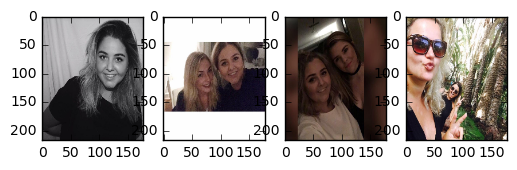

[[ 0.76090431]
 [ 0.21827149]
 [ 0.45907152]
 [ 0.52980316]]
Too ugly! 0.492012619972


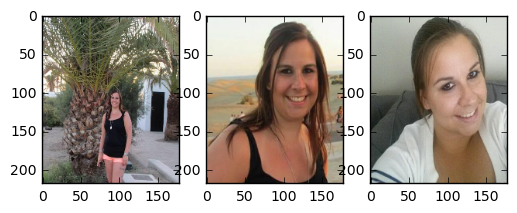

[[ 0.59142822]
 [ 0.20313099]
 [ 0.691324  ]]
Too ugly! 0.495294411977


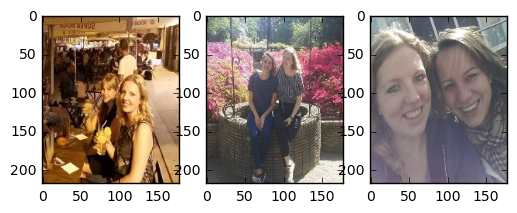

[[ 0.55833745]
 [ 0.09531528]
 [ 0.50004429]]
Too ugly! 0.384565671285


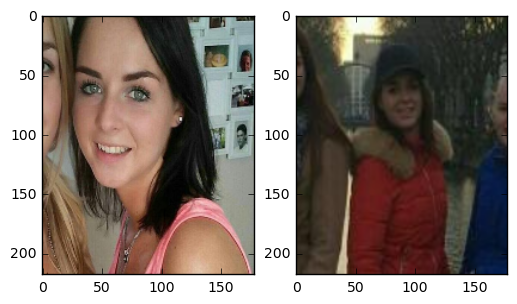

[[ 0.73063302]
 [ 0.11783013]]
Too ugly! 0.42423158884


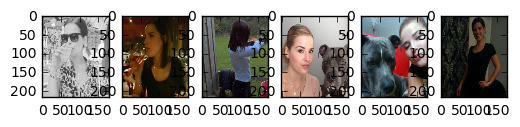

[[ 0.79900956]
 [ 0.52748084]
 [ 0.71886104]
 [ 0.65929466]
 [ 0.35147965]
 [ 0.11549747]]
Too ugly! 0.528603871663


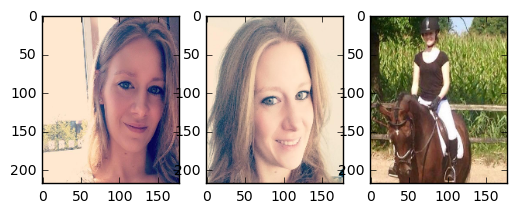

[[ 0.29262811]
 [ 0.73681784]
 [ 0.79839528]]
Very pretty! 0.609280387561


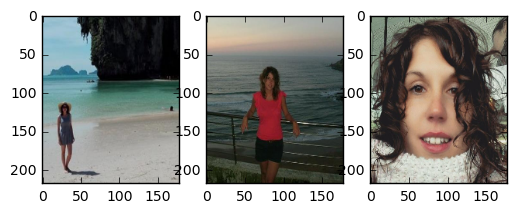

[[ 0.78586376]
 [ 0.19443482]
 [ 0.47084486]]
Too ugly! 0.483714501063


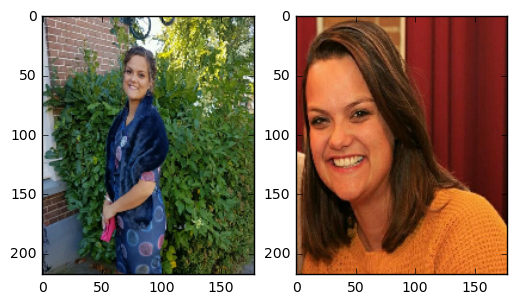

[[ 0.47153875]
 [ 0.49233443]]
Too ugly! 0.481936573982


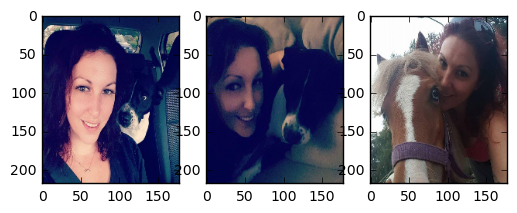

[[ 0.39657414]
 [ 0.52707672]
 [ 0.40928882]]
Too ugly! 0.444313208262


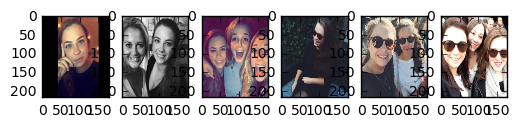

[[ 0.08486366]
 [ 0.73113179]
 [ 0.52700853]
 [ 0.2958594 ]
 [ 0.83000535]
 [ 0.83578742]]
Too ugly! 0.550776004791


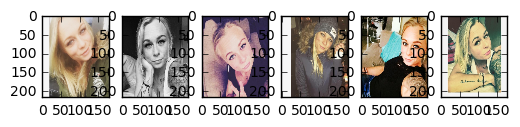

[[ 0.67690545]
 [ 0.44912106]
 [ 0.40806788]
 [ 0.73354697]
 [ 0.13753462]
 [ 0.39320028]]
Too ugly! 0.466396013896


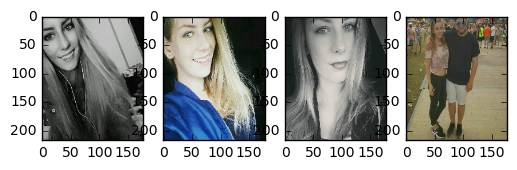

[[ 0.48822486]
 [ 0.26184341]
 [ 0.63169205]
 [ 0.72676259]]
Too ugly! 0.527130723


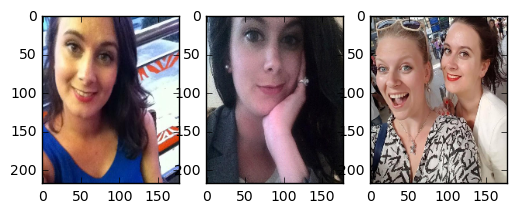

[[ 0.37874377]
 [ 0.6459772 ]
 [ 0.44160366]]
Too ugly! 0.488774855932


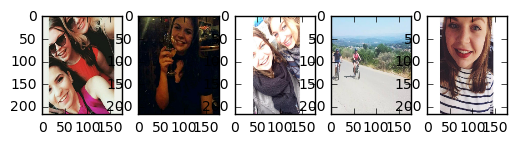

[[ 0.22576928]
 [ 0.55859828]
 [ 0.38046402]
 [ 0.84435952]
 [ 0.63648671]]
Too ugly! 0.529135560989


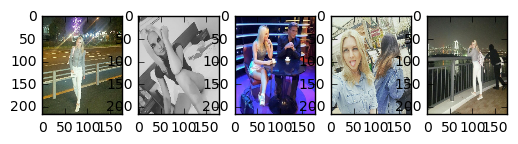

[[ 0.75261247]
 [ 0.56530267]
 [ 0.12223238]
 [ 0.81483853]
 [ 0.26722586]]
Too ugly! 0.504442405701


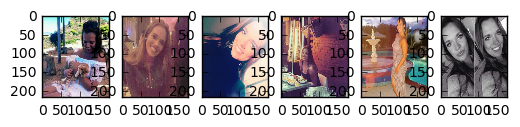

[[ 0.61824989]
 [ 0.56698787]
 [ 0.39060137]
 [ 0.47063127]
 [ 0.83750975]
 [ 0.33980447]]
Too ugly! 0.537297447522


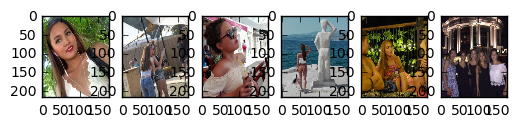

[[ 0.70758939]
 [ 0.38884637]
 [ 0.64252043]
 [ 0.6484257 ]
 [ 0.50147349]
 [ 0.23392993]]
Too ugly! 0.520464221636


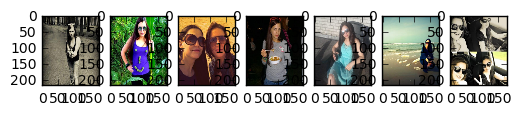

[[ 0.39273429]
 [ 0.63919288]
 [ 0.40379119]
 [ 0.464854  ]
 [ 0.77273989]
 [ 0.7440033 ]
 [ 0.3294946 ]]
Too ugly! 0.53525856563


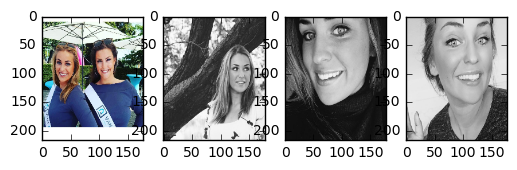

[[ 0.14502263]
 [ 0.68631935]
 [ 0.83699667]
 [ 0.35578689]]
Too ugly! 0.506031394005


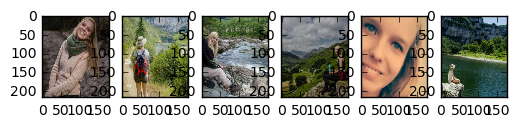

[[ 0.69325709]
 [ 0.74408352]
 [ 0.63240218]
 [ 0.50626993]
 [ 0.7163021 ]
 [ 0.12875089]]
Too ugly! 0.570177594821


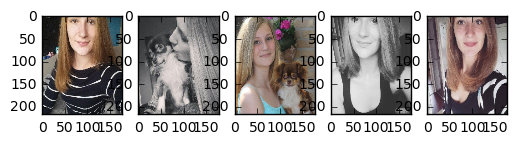

[[ 0.08799371]
 [ 0.77439082]
 [ 0.3248491 ]
 [ 0.72530496]
 [ 0.58409792]]
Too ugly! 0.499327325821


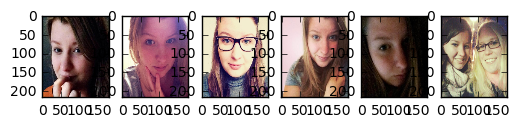

[[ 0.41444764]
 [ 0.1505999 ]
 [ 0.65831554]
 [ 0.52793503]
 [ 0.63831294]
 [ 0.74132246]]
Too ugly! 0.521822253863


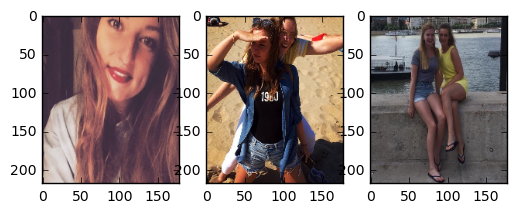

[[ 0.79454172]
 [ 0.28333974]
 [ 0.53269851]]
Too ugly! 0.536859989166


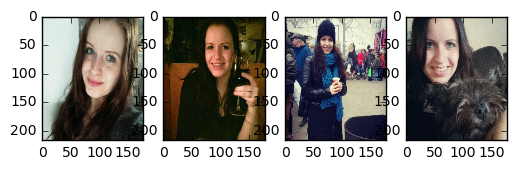

[[ 0.8219974 ]
 [ 0.3234266 ]
 [ 0.50891352]
 [ 0.22449765]]
Too ugly! 0.469708800316


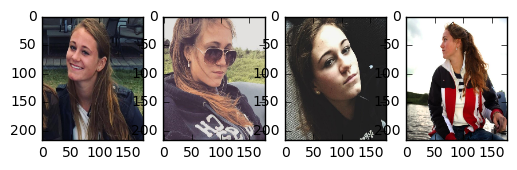

[[ 0.50804263]
 [ 0.6406908 ]
 [ 0.23321792]
 [ 0.75404507]]
Too ugly! 0.533999085426
['Annelies', 'Veronika', 'Joëlle', 'Daphne', 'Danique', 'Suzan', 'Anniek', 'Arielle', 'Lieke']


In [38]:
def create_collage(images):
    fig = plt.figure()
    for index,image in enumerate(images):
        subplot_index = 100+10*len(images)+(index+1)
        plt.subplot(subplot_index)
        plt.imshow(image)
    plt.show()
def estimate_prettyness(user):
    images = []
    for photo_url in user.photos:
        path = utils.download(photo_url)
        image = plt.imread(path)
        image = resize_image(image,IMAGE_WIDTH,IMAGE_HEIGHT)
        images.append(image)


    input_network = np.array(images)
    beauty = sess.run(lin6, feed_dict={input_placeholder:input_network})
    create_collage(images)
    print(beauty)
    average_beauty = np.sum(beauty)/len(beauty)
    if average_beauty < 0.6:
        print("Too ugly! " + str(average_beauty))
        user.dislike()
    else:
        print("Very pretty! " + str(average_beauty))
        user.like()

    

for _ in range(3):
    users = session.nearby_users() # returns a list of users nearby
    for user in users:
        estimate_prettyness(user)
    
    
print(users)